## Mike's Musings on Setting up the Toy Problem

#### Setting up Environment for Computing
This cell reads from site_settings.yml file (top directory of ssim-ghg repos) and sets up environment, including directory references and libraries. Many more libraries and code scripts are read via the setup() function.

In [ ]:
settings <- yaml::read_yaml('../site_settings.yml')

Rcode_dir <- getwd()
data_dir <- settings$global_paths$input_folder
output_dir <- settings$global_paths$output_folder

cat(paste("Using", data_dir, "for data directory\n"))
cat(paste("Using", output_dir, "for output directory\n"))
cat(paste("Using", Rcode_dir, "for RCode dir\n"))

#--  Load utility code file w/ setup()
source(file.path(Rcode_dir,"util_code_032024.R"))
setup()

### Pieces of an inversion

Recall that there are several parts that go into an inversion:

- The state space $\mathbf{x}$, it's prior mean $\mathbf{x}_0$, and prior covariance $\mathbf{S}_0$
- Observations $\mathbf{z}$, with error covariance $\mathbf{S}_z$
- Jacobian mapping state to obs: $\mathbf{H}$

We load and explore each piece below, in particular $\mathbf{x}$, $\mathbf{x}_0$, $\mathbf{z}$, and $\mathbf{H}$.

### Inversion state space and prior mean

The toy example is constructed to infer global CO2 fluxes from simulated observations. The state space is a relatively simple "scaling factor" setup.

#### Gridded prior mean flux

Everything starts with a gridded prior or bottom-up estimates of the fluxes. This takes the form of the average flux in each grid cell (5 degrees latitude, 4 degrees longitude) and month (from 2014-09 to 2016-08, inclusive).

We load the prior gridded flux now. Don't worry too much about how it's loaded.

In [ ]:
fn <- nc_open(file.path(data_dir, "priors/prior_SiB4.nc"))
date <- seq(as.Date('2014-09-01'), as.Date('2016-08-01'), by = '1 month')
prior_flux <- expand.grid(
  lon = as.vector(ncvar_get(fn, 'longitude')),
  lat = as.vector(ncvar_get(fn, 'latitude')),
  time = date[as.vector(ncvar_get(fn, 'time')) + 1L]  # Map time (offset) to actual date
)
prior_flux$value <- as.vector(ncvar_get(fn, 'NEE'))
nc_close(fn)

We can look at the columns in the resulting data frame:

In [ ]:
str(prior_flux)

We have a value for each longitude, latitude, and time.

We now plot each month of prior mean fluxes:

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 30, repr.plot.res = 150)

ggplot(prior_flux %>% filter(abs(lat) != 89), aes(lon, lat, fill = value)) +
  geom_tile() +
  geom_map() +
  scale_fill_gradient2() +
  coord_quickmap() +
  facet_wrap(~ time, ncol = 2)

We can aggregate this to monthly fluxes (this requires area weighting and some minor unit conversions, as you see below):

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 150)

# Load the grid cell areas
fn <- nc_open(file.path(data_dir, 'areas', 'area_5x4.nc'))
area_5x4 <- expand.grid(
  lon = as.vector(ncvar_get(fn, 'lon')),
  lat = as.vector(ncvar_get(fn, 'lat'))
)
area_5x4$lat[abs(area_5x4$lat) != 89] <- area_5x4$lat[abs(area_5x4$lat) != 89] - 1L
area_5x4$area <- as.vector(ncvar_get(fn, 'grid_cell_area'))
nc_close(fn)

# Aggregate and plot global totals
MICROMOL_CO2_SEC_TO_PGC_MO <- 44.01 * 365.25 * 24 * 60 * 60 * 1e-15 / 12
prior_flux %>%
  left_join(area_5x4, by = c('lon', 'lat')) %>%
  group_by(time) %>%
  summarise(value = sum(value * area * MICROMOL_CO2_SEC_TO_PGC_MO)) %>%
  ggplot(aes(time, value)) +
    geom_line()

##### State space

The state space works by adjusting the grid cell level fluxes in each of 22 major regions by a **scaling** factor.

That is, if $f_0$ is the prior flux in a grid cell in region $r$ and month $t$, it's flux $f$ is modelled as $f = f_0 \times x_{r, t}$.

We let the prior mean of $x_{r, t}$ be $x_{0, r, t} = 1$, so the prior mean flux is $f_0$. We are therefore **centering the inversion on our prior best-guess**.  We occasionally recast this problem as an *anomaly* to the prior, where the model form is $f = f_0 \times (1+x_{r, t})   \implies   f = f_0 \times 1 + f_0 \times x_{r, t}   \implies   f - f_0 = f_0 \times x_{r, t}$, where $x_{r, t}$ is now centered around 0.

The regions are the ubiquitous 22 TransCom regions, and the scaling looks like this:

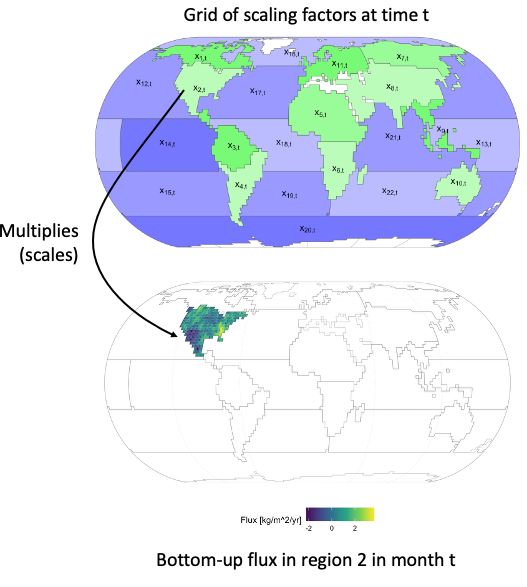

There are 24 months. Therefore, there are $22 \times 24 = 528$ state elements. 11 regions correspond to land (1 through 11), and 11 to ocean (12 through 22).

We haven't made a covariance matrix for the state space; we'll do that a bit later.

#### Observations

We now load the observation catalog, which has all the observations $\mathbf{z}$ we could use:

In [ ]:
load(file.path(data_dir,"obs", "obs_catalog_042424_unit_pulse_hour_timestamp_witherrors_withdates.rda"))

Let's look at the structure of the loaded data frame using the `str()` function.

In [ ]:
str(obs_catalog)

This has:

- 1156383 observations (rows); quite a lot!
- The main columns are:
  - type
  - id
  - longitude
  - latitude
  - SD (explained later)
  - date

Let us look at which values of TYPE and how many:

In [ ]:
print(table(obs_catalog$TYPE))

Let's break things out by month and type and plots counts:

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 150)

obs_catalog %>%
  group_by(TYPE, YEAR, MONTH) %>%
  summarise(n = n(), .groups = "drop") %>%
  mutate(YEAR_MONTH = as.Date(sprintf('%04d-%02d-15', YEAR, MONTH))) %>%
  ggplot(aes(YEAR_MONTH, n, colour = TYPE)) +
    geom_line()

Let's plot the observation locations for one week of OCO-2 (these are snapped to grid cell centers):

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 150)

obs_catalog %>%
  filter(TYPE == "OCO2", DATE >= '2015-01-01', DATE < '2015-01-08') %>%
  ggplot(aes(LON, LAT)) +
    geom_map() +
    geom_point(colour = 'blue', size = 0.5) +
    coord_quickmap()

Let's plot all locations for TCCON and IS; these are mostly at fixed sites, but each site can have lots! The colour indicates the data volumn (log scale):

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 150)

obs_catalog %>%
  filter(TYPE %in% c("IS", "TCCON")) %>%
  group_by(TYPE, LON, LAT) %>%
  summarise(n = n(), .groups = 'drop') %>%
  ggplot(aes(LON, LAT, colour = n, shape = TYPE)) +
    geom_map() +
    geom_point() +
    scale_colour_viridis_c(trans = 'log10') +
    coord_quickmap()

#### Jacobian

We now load the Jacobian $\mathbf{H}$. Remember, this is a matrix that maps from state space ($\mathbf{x}$) to observation space ($\mathbf{z}$).

In [ ]:
load(file.path(data_dir, "jacobians", "trunc_full_jacob_030624_with_dimnames_sib4_4x5_mask.rda"))
load(file.path(data_dir, "jacobians", "jacob_bgd_060524.rda"))

H <- jacob * 12/44
H_bgd <- jacob_bgd 
rm(jacob)
rm(jacob_bgd)

# These represent the fossil and biomass burning contributions to the observations (from fixed emission runs)
fire_fixed <- H_bgd[, 2]
fossil_fixed <- H_bgd[, 3]

Two matrices are actually loaded: $H$ and $H_{bgd}$. The first is the usual Jacobian, the second contains some aspects of the problem that are **fixed**, in this case fire and fossil fuel fluxes and their contributions to the modelled observations. This is a CO2 specific set up and not that important.

Let's look at the structure and shape of $H$:

In [ ]:
str(H)

The number of rows is the same as the number of observations. The number of columns is the same as our state space.

The column names tell you which month and region the state vector corresponds to:

- nee_regionRegion01_month2014-09: region 1, month 2014-09
- nee_regionRegion01_month2014-10: region 1, month 2014-10
- ...

Let's plot the column for region 2 (Temperate North America), month 2014-10 of the Jacobian for a few months of OCO-2 measurements. We'll draw a random sample of 10000 observations to make this easier:

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 7, repr.plot.res = 150)

obs_catalog %>%
  mutate(jacobian = H[, 'nee_regionRegion02_month2014-10']) %>%
  filter(YEAR == 2014, TYPE == 'OCO2') %>%
  sample_n(10000) %>%
  mutate(year_month = sprintf('%04d-%02d', YEAR, MONTH)) %>%
  ggplot(aes(LON, LAT, colour = pmax(pmin(jacobian, 0.5), -0.5))) +
    geom_map() +
    geom_point() +
    coord_quickmap() +
    scale_colour_gradient2() +
    facet_wrap(~ year_month)


For observations in 2014-09, the Jacobian is zero. Why? Because the state vector adjusts fluxes in 2014-10, **which has not happened yet.**

In 2014-10, the Jacobian is large over region 2, which is Temperate North America. Then in 2014-11 and 2014-12, the impact is still felt but it is spread out by transport.


In [ ]:
sessionInfo()
#show info